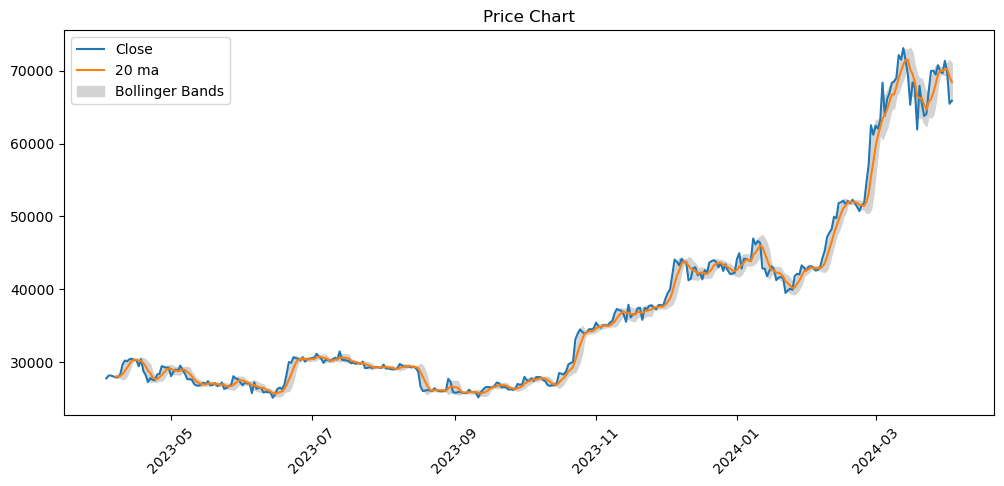

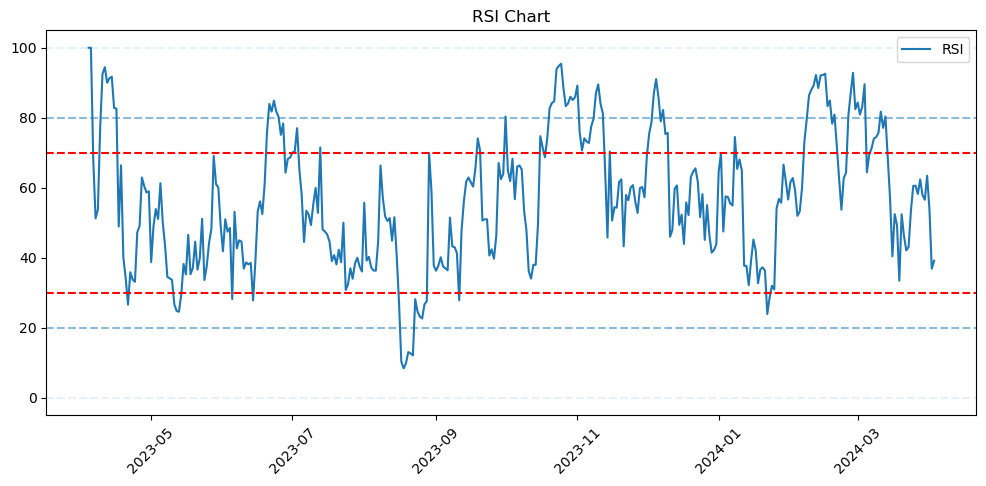

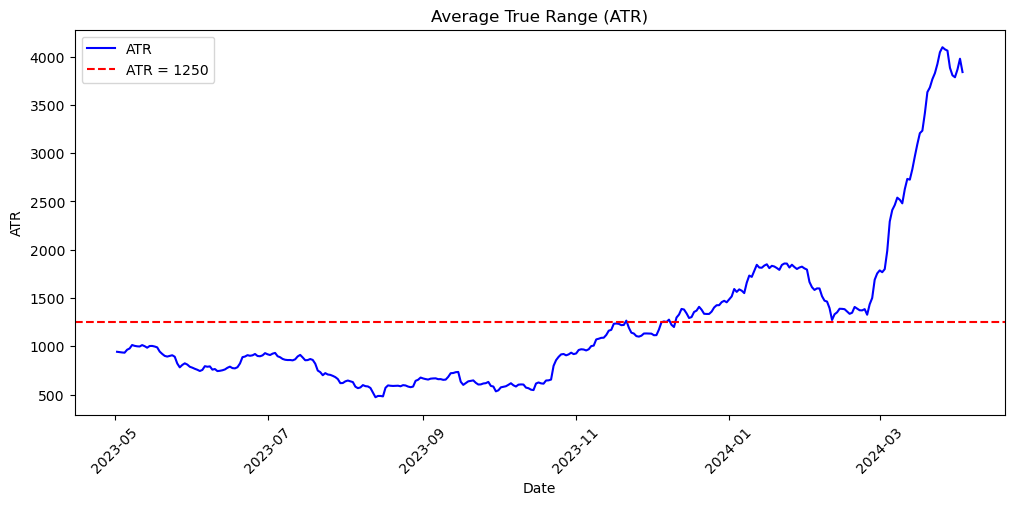

In [170]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

btc_data = pd.read_csv('BTC-USD-Test.csv')
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

def calculate_bollinger_bands(df, window=5):
    df['rolling_mean'] = df['Close'].rolling(window=window).mean()
    df['std'] = df['Close'].rolling(window=window).std()
    df['upper_band'] = df['rolling_mean'] + (df['std'] * 1)
    df['lower_band'] = df['rolling_mean'] - (df['std'] * 1)
    #plot for validation
    plt.figure(figsize=(12,5))
    plt.xticks(rotation=45)

    x_axis = df['Date']

    plt.plot(x_axis, df['Close'], label = 'Close')
    plt.plot(df['Date'], df['rolling_mean'], label = '20 ma')
    plt.fill_between(x_axis, df['upper_band'], df['lower_band'], label = 'Bollinger Bands', color='lightgrey')

    plt.title('Price Chart')
    plt.legend()
    plt.show()
    return df

def calculate_rsi(df, window=6):
    df['delta'] = df['Close'].diff()
    df['gain'] = df['delta'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['delta'].apply(lambda x: abs(x) if x < 0 else 0)
    #Calculate ema 
    df['ema_gain'] = df['gain'].ewm(window).mean()
    df['ema_loss'] = df['loss'].ewm(window).mean()

    #Calculate RSI
    df['rs'] = df['ema_gain']/df['ema_loss']
    df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))
    #plot for validation
    plt.figure(figsize=(12,5))
    plt.xticks(rotation=45)

    x_axis = df['Date']

    plt.plot(x_axis, df['rsi'], label = 'RSI')
    plt.axhline(0, linestyle='--', alpha=0.1)
    plt.axhline(20, linestyle='--', alpha=0.5)
    plt.axhline(30, linestyle='--', color='red')

    plt.axhline(70, linestyle='--', color='red')
    plt.axhline(80, linestyle='--', alpha=0.5)
    plt.axhline(100, linestyle='--', alpha=0.1)

    plt.title('RSI Chart')
    plt.legend()
    plt.show()

    return df

btc_data = calculate_bollinger_bands(btc_data)
btc_data = calculate_rsi(btc_data)

# Calculate the True Range (TR)
btc_data['High-Low'] = btc_data['High'] - btc_data['Low']
btc_data['High-PrevClose'] = abs(btc_data['High'] - btc_data['Close'].shift(1))
btc_data['Low-PrevClose'] = abs(btc_data['Low'] - btc_data['Close'].shift(1))
btc_data['TR'] = btc_data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

# Calculate the Average True Range (ATR)
period = 30  # You can adjust this period as needed
btc_data['ATR'] = btc_data['TR'].rolling(window=period).mean()

# Plot the ATR indicator
plt.figure(figsize=(12, 5))
plt.plot(btc_data['Date'], btc_data['ATR'], label='ATR', color='blue')
plt.axhline(y=1250, color='red', linestyle='--', label='ATR = 1250')  # Plot horizontal line at ATR = 1000
plt.title('Average True Range (ATR)')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.xticks(rotation=45)
plt.legend()
plt.show()



Buying at 26804.990234 on 2023-05-12 00:00:00
Selling at 30027.296875 on 2023-06-21 00:00:00
Buying at 26664.550781 on 2023-08-17 00:00:00
Selling at 27132.007813 on 2023-09-20 00:00:00
Buying at 39845.550781 on 2024-01-23 00:00:00
Selling at 45301.566406 on 2024-02-08 00:00:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 3
Number of Gains: 3
Number of Losses: 0
Win Rate: 100.0%
Average Gain: 9.16%
Average Loss: 0%
Max Return: 13.69%
Max Loss: undefined%
Total Returns with compounding: 29.59%
Total Return wihtout compounding: 27.47%



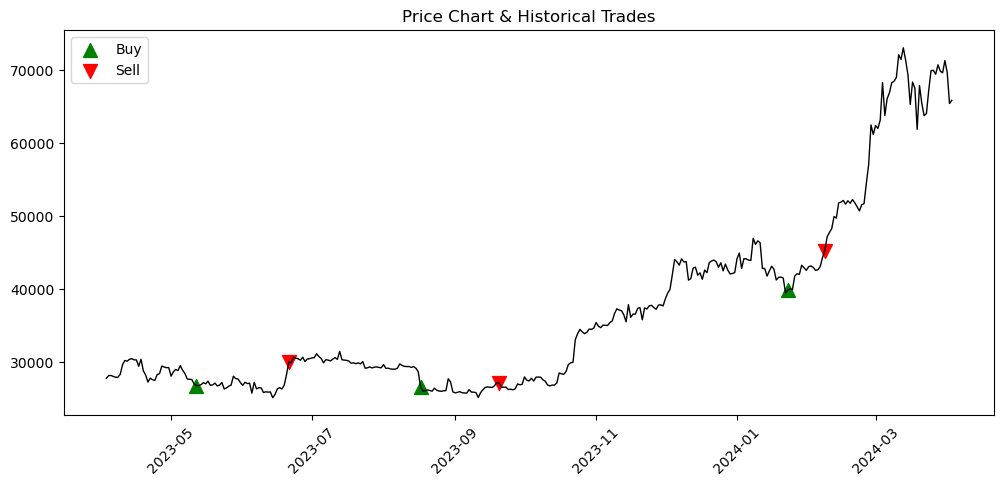

In [171]:
df = btc_data

# Create a strategy
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_band']) & (df['ATR'] < 2000), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['Close'] > df['upper_band']) & (df["ATR"] < 2000), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Close"][i]
        date = df['Date'][i]

        # Buy action
        if df["signal"][i] == 1:
            if position == 0:
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif df["signal"][i] == -1:
            if position == 1:
                stop_loss_price = buy_price * 0.90  # 10% stop loss
                if close <= stop_loss_price:  # Check if stop loss triggered
                    sell_price = stop_loss_price
                    position = 0
                    df.at[i, 'sell_date'] = date
                    print(f"Stop Loss triggered at {str(sell_price)} on {str(date)}")
                else:
                    sell_price = close
                    position = 0
                    df.at[i, 'sell_date'] = date
                    print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price / buy_price - 1) * 100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if i > 0:
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i / 100) + 1)

    totalR = round((totalR - 1) * 100, 2)

    total_return = round(gains + losses, 2)

    if ng > 0:
        avgGain = round(gains / ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if nl > 0:
        avgLoss = round(losses / nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if ng > 0 or nl > 0:
        win_rate = round((ng / (ng + nl)) * 100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng + nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print(f"Total Returns with compounding: {totalR}%")
    print(f"Total Return wihtout compounding: {total_return}%")
    print()

backtest_dataframe(df)

plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

plt.plot(df['Date'], df['Close'], c = 'black', lw = 1)
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['Close'], label='Buy', marker='^', c='g', s=100)
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['Close'], label='Sell', marker='v', c='r', s=100)

plt.title('Price Chart & Historical Trades')
plt.legend()
plt.show()


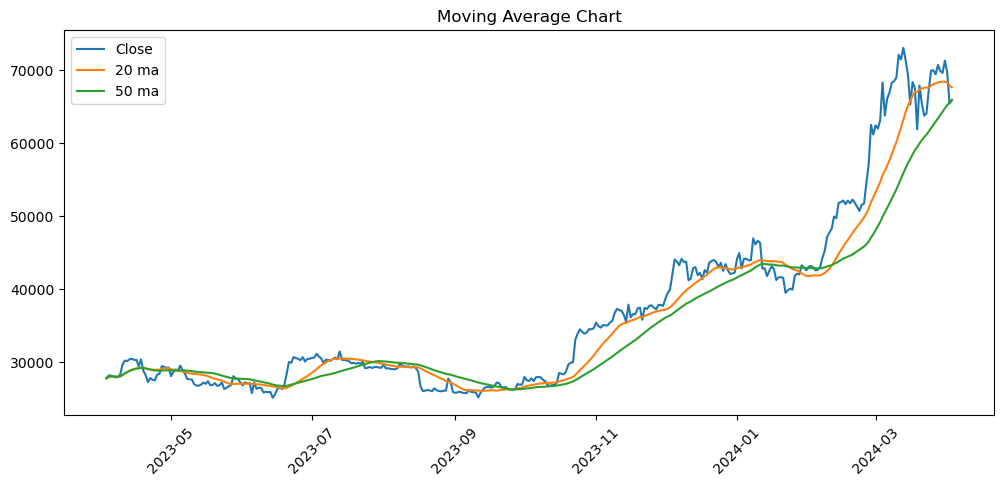

In [172]:
def calculate_moving_average(df, short_window, long_window):
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    #plot for validation
    plt.figure(figsize=(12,5))
    plt.xticks(rotation=45)

    x_axis = df['Date']

    plt.plot(x_axis, df['Close'], label = 'Close')
    plt.plot(df['Date'], df['Short_MA'], label = '20 ma')
    plt.plot(df['Date'], df['Long_MA'], label = '50 ma')

    plt.title('Moving Average Chart')
    plt.legend()
    plt.show()
    return df

btc_data = calculate_moving_average(btc_data, 20, 40)

# Create a strategy
#buy signal
btc_data['Signal'] = np.where(
    (btc_data['Short_MA'] > btc_data['Long_MA']) &
    (btc_data['ATR'] > 500), 1, np.nan)

#sell signal
btc_data['Signal'] = np.where(
   (btc_data['Short_MA'] < btc_data['Long_MA']) &
   (btc_data['ATR'] > 500), -1, btc_data['Signal'])


Buying at 28680.537109 on 2023-05-02 00:00:00
Selling at 28847.710938 on 2023-05-04 00:00:00
Buying at 30548.695313 on 2023-06-24 00:00:00
Selling at 29319.246094 on 2023-07-28 00:00:00
Buying at 26298.480469 on 2023-09-25 00:00:00
Selling at 40077.074219 on 2024-01-24 00:00:00
Buying at 49958.222656 on 2024-02-12 00:00:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 3
Number of Gains: 2
Number of Losses: 1
Win Rate: 66.67%
Average Gain: 26.49%
Average Loss: -4.02%
Max Return: 52.39%
Max Loss: -4.02%
Total Returns with compounding: 47.11%
Total Return wihtout compounding: 48.95%



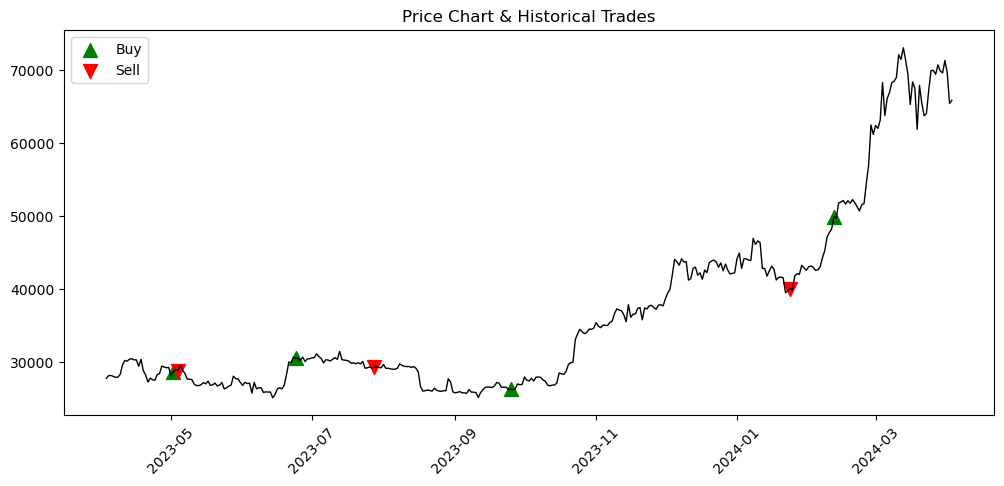

In [173]:

def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['Buy_date'] = ''
    df['Sell_date'] = ''

    for i in df.index:
        close = df["Close"][i]
        date = df['Date'][i]

        # Buy action
        if df["Signal"][i] == 1:
            if position == 0:
                buy_price = close
                position = 1
                df.at[i, 'Buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif df["Signal"][i] == -1:
            if position == 1:
                stop_loss_price = buy_price * 0.90  # 10% stop loss
                if close <= stop_loss_price:  # Check if stop loss triggered
                    sell_price = stop_loss_price
                    position = 0
                    df.at[i, 'Sell_date'] = date
                    print(f"Stop Loss triggered at {str(sell_price)} on {str(date)}")
                else:
                    sell_price = close
                    position = 0
                    df.at[i, 'Sell_date'] = date
                    print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price / buy_price - 1) * 100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if i > 0:
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i / 100) + 1)

    totalR = round((totalR - 1) * 100, 2)

    total_return = round(gains + losses, 2)

    if ng > 0:
        avgGain = round(gains / ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if nl > 0:
        avgLoss = round(losses / nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if ng > 0 or nl > 0:
        win_rate = round((ng / (ng + nl)) * 100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng + nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print(f"Total Returns with compounding: {totalR}%")
    print(f"Total Return wihtout compounding: {total_return}%")
    print()

backtest_dataframe(btc_data)

plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

plt.plot(df['Date'], df['Close'], c = 'black', lw = 1)
plt.scatter(df[(df['Signal'] == 1)]['Buy_date'], df[(df['Signal'] == 1)]['Close'], label='Buy', marker='^', c='g', s=100)
plt.scatter(df[(df['Signal'] == -1)]['Sell_date'], df[(df['Signal'] == -1)]['Close'], label='Sell', marker='v', c='r', s=100)

plt.title('Price Chart & Historical Trades')
plt.legend()
plt.show()

